## Preparar el entorno y librerías


En esta sección instalamos (si es necesario) y cargamos las librerías que usaremos. Explico brevemente por qué las necesitamos.


- `numpy`, `pandas` — manejo de arrays/tablas
- `matplotlib` — visualización
- `scikit-learn` — implementaciones de PCA, t-SNE, modelos y utilidades
- `umap` — alternativa moderna para visualización (opcional: requiere instalación)


Nota: en entornos controlados puede que necesites ejecutar `pip install umap-learn`.

In [19]:
# Código: importar librerías y (si se desea) instalar paquetes opcionales
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report


# Intentar importar umap; si no existe, mostrar instrucción para instalar
try:
    import umap
    umap_available = True
except Exception:
    umap_available = False
    # No ejecutamos pip desde aquí para no forzar instalaciones automáticas en entornos educativos
    print("La librería 'umap-learn' no está instalada. Para instalarla, ejecuta: pip install umap-learn")


# Ajustes de visualización
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


# Semilla global para reproducibilidad
RANDOM_STATE = 42


print('Entorno listo. UMAP disponible:', umap_available)

Entorno listo. UMAP disponible: True


## Dataset de ejemplo: iris y dígitos


Usaremos dos conjuntos:
- `iris` (pequeño, 4 características) para ejemplos rápidos y visualización.
- `digits` (imágenes 8x8) para ejemplos de compresión y reconstrucción.

In [20]:
# Cargar datasets
iris = datasets.load_iris(as_frame=True)
X_iris = iris.data
y_iris = iris.target


digits = datasets.load_digits()
X_digits = digits.data # cada fila: 64 pixeles
y_digits = digits.target


print('Iris:', X_iris.shape)
print('Digits:', X_digits.shape)

Iris: (150, 4)
Digits: (1797, 64)


## Ejemplo 1 — Visualización con PCA (Iris)


Objetivo: reducir a 2 dimensiones para visualizar la separación entre clases. PCA es una técnica lineal que maximiza la varianza.


Explicación en clase:
- Estandarizamos antes de PCA (si las variables están en distintas escalas).
- Mostraremos la proporción de varianza explicada por cada componente.

Explained variance ratio: [0.72962445 0.22850762]


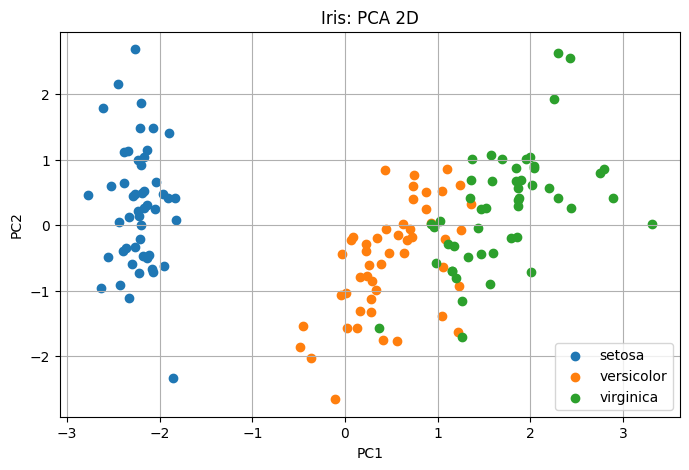

In [21]:
# Estandarizar y aplicar PCA
scaler = StandardScaler()
X_iris_s = scaler.fit_transform(X_iris)


pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_iris_pca = pca.fit_transform(X_iris_s)


print('Explained variance ratio:', pca.explained_variance_ratio_)


# Visualizar
fig, ax = plt.subplots()
for label in np.unique(y_iris):
    ax.scatter(X_iris_pca[y_iris==label, 0], X_iris_pca[y_iris==label, 1], label=iris.target_names[label])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Iris: PCA 2D')
ax.legend()
plt.show()

## Ejemplo 2 — Visualización no lineal: t-SNE (Iris)


t-SNE es útil para visualizar estructuras locales en datos no lineales. Es determinista solo si fija `random_state` y `perplexity` y puede ser costoso en tiempo.


Puntos a comentar con alumnos:
- t-SNE no preserva distancias globales ni eje interpretables como PCA.
- Es sensible a la elección de `perplexity` y la semilla.

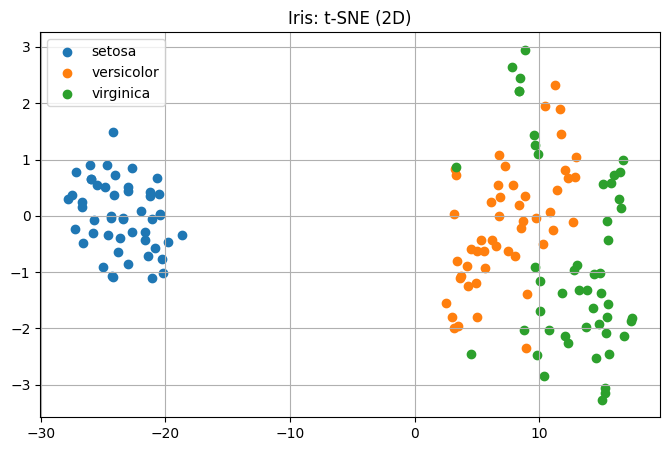

In [22]:
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, init='pca')
X_iris_tsne = tsne.fit_transform(X_iris_s)


fig, ax = plt.subplots()
for label in np.unique(y_iris):
    ax.scatter(X_iris_tsne[y_iris==label, 0], X_iris_tsne[y_iris==label, 1], label=iris.target_names[label])
ax.set_title('Iris: t-SNE (2D)')
ax.legend()
plt.show()

## Ejemplo 3 — UMAP (si está disponible)


UMAP (Uniform Manifold Approximation and Projection) suele ser más rápido que t-SNE y preserva mejor la estructura global/local. Requiere `umap-learn`.

c:\Users\Teo Ramos\Desktop\trabajo\IA_80h\Bootcamp FactoriaF5\Reduccion de dimensionalidad\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


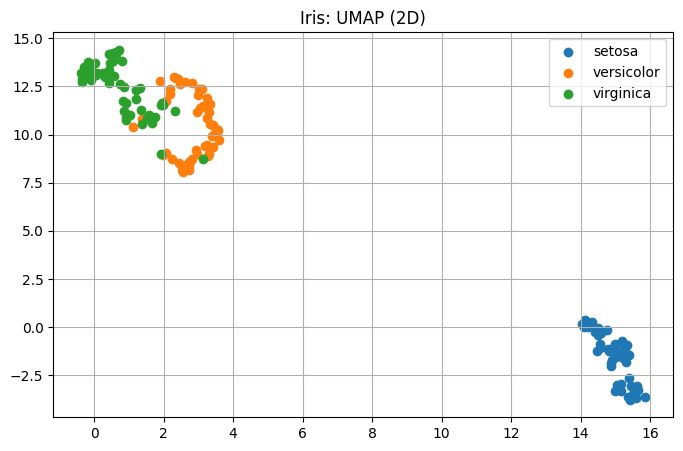

In [23]:
if umap_available:
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    X_iris_umap = reducer.fit_transform(X_iris_s)
    fig, ax = plt.subplots()
    for label in np.unique(y_iris):
        ax.scatter(X_iris_umap[y_iris==label, 0], X_iris_umap[y_iris==label, 1], label=iris.target_names[label])
    ax.set_title('Iris: UMAP (2D)')
    ax.legend()
    plt.show()
else:
    print('UMAP no disponible — instala umap-learn para ejecutar este bloque')

## Caso práctico: reducción de dimensionalidad como preprocesado para clasificación


Idea: aplicamos reducción de dimensionalidad (PCA) antes de entrenar un clasificador y comparamos con usar las características originales. Esto puede acelerar el entrenamiento y reducir overfitting si reducimos ruido.


Protocolo:
- Train/test split
- Estandarizar
- Pipeline: PCA (varias componentes) + LogisticRegression
- Medir accuracy y tiempo (a nivel demostrativo)

In [24]:
from time import time


# Train/test
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=RANDOM_STATE, stratify=y_digits)


# Estandarizar
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


# Modelo sin reducción
clf_raw = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
start = time()
clf_raw.fit(X_train_s, y_train)
raw_time = time() - start
pred_raw = clf_raw.predict(X_test_s)
acc_raw = accuracy_score(y_test, pred_raw)


# Modelo con PCA reduciendo a 20 componentes
pca20 = PCA(n_components=20, random_state=RANDOM_STATE)
X_train_pca = pca20.fit_transform(X_train_s)
X_test_pca = pca20.transform(X_test_s)
clf_pca = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
start = time()
clf_pca.fit(X_train_pca, y_train)
pca_time = time() - start
pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, pred_pca)


print(f'Raw features: acc={acc_raw:.4f}, train_time={raw_time:.3f}s')
print(f'PCA(20) : acc={acc_pca:.4f}, train_time={pca_time:.3f}s')
print('Explained variance by 20 components:', np.sum(pca20.explained_variance_ratio_))

Raw features: acc=0.9815, train_time=0.064s
PCA(20) : acc=0.9463, train_time=0.048s
Explained variance by 20 components: 0.8000441638952808


## Ejemplo: compresión y reconstrucción de imágenes con PCA (Digits)


Explicación:
- Tratar las imágenes como vectores y usar PCA para guardarlas con menos componentes.
- Reconstrucción: `inverse_transform` de PCA y medir error de reconstrucción.


En clase: mostrar imágenes abajo — comparad original vs reconstrucción con distinto número de componentes.

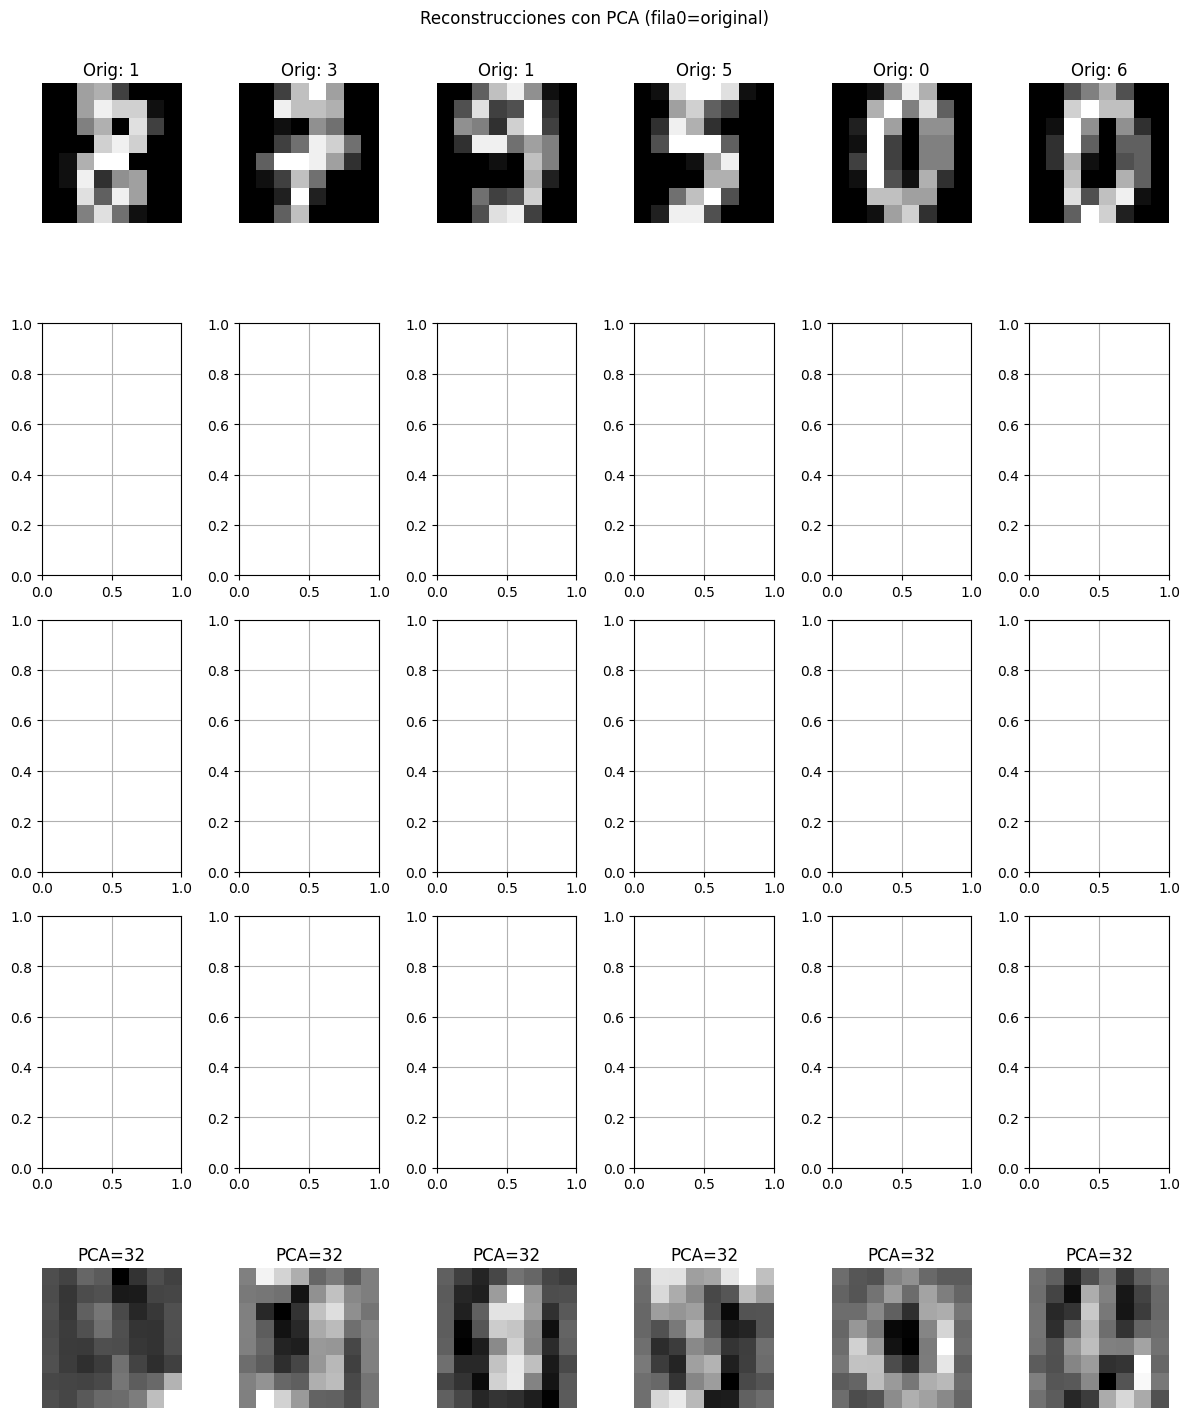

In [25]:
# Tomaremos algunas imágenes de test
n_show = 6
inds = np.random.RandomState(RANDOM_STATE).choice(len(X_test), size=n_show, replace=False)


components_list = [2, 8, 16, 32]
fig, axes = plt.subplots(len(components_list)+1, n_show, figsize=(12, 3*(len(components_list)+1)))


# imagen original (fila 0)
for j, idx in enumerate(inds):
    axes[0, j].imshow(X_test[idx].reshape(8,8), cmap='gray')
    axes[0, j].set_title(f'Orig: {y_test[j] if j < len(y_test) else "?"}')
    axes[0, j].axis('off')


for i, n_comp in enumerate(components_list):
    pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_train_small = scaler.fit_transform(X_train) # recalculo para cada prueba (sencillo y claro en clase)
    pca.fit(X_train_small)
    X_test_small = scaler.transform(X_test)
    X_test_proj = pca.transform(X_test_small)
    X_test_rec = pca.inverse_transform(X_test_proj)


for j, idx in enumerate(inds):
    axes[i+1, j].imshow(X_test_rec[j].reshape(8,8), cmap='gray')
    axes[i+1, j].set_title(f'PCA={n_comp}')
    axes[i+1, j].axis('off')


plt.suptitle('Reconstrucciones con PCA (fila0=original)')
plt.tight_layout()
plt.show()

## Ejemplo: reducción para eliminación de ruido (denoising)


Técnica demostrativa:
- Añadir ruido gaussiano a imágenes y usar PCA para reconstruir y eliminar parte del ruido.

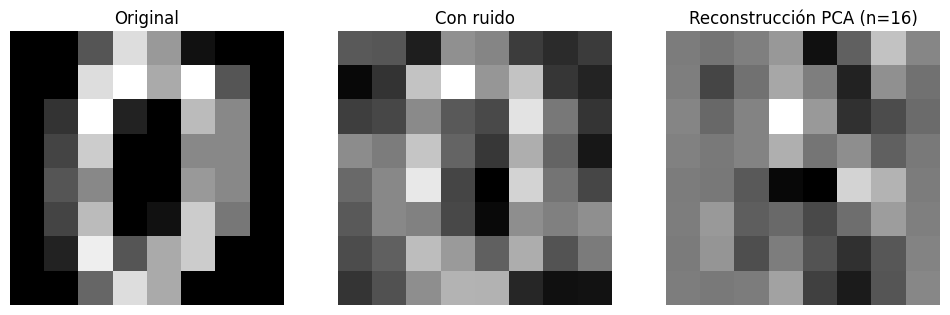

In [26]:
img = X_digits[0].reshape(8,8)
noisy = img + np.random.normal(scale=4.0, size=img.shape)

# Prepara datos: X_digits ya definidos (cada fila = 64 pixeles)
# 1) Escalar todo el dataset con StandardScaler (evita división por 0 internamente)
scaler = StandardScaler()
X_digits_s = scaler.fit_transform(X_digits)  # fit en todo el dataset

# 2) Entrenar PCA en los datos escalados
n_components = 16
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
pca.fit(X_digits_s)

# 3) Preparar vector ruidoso con la misma escala (usar scaler.transform)
noisy_vec_raw = noisy.reshape(1, -1)            # forma (1,64) en escala original
noisy_vec_s = scaler.transform(noisy_vec_raw)   # escala consistente (no división por 0)

# 4) Proyección y reconstrucción en el subespacio PCA (en escala estandarizada)
proj = pca.transform(noisy_vec_s)
rec_s = pca.inverse_transform(proj)

# 5) Volver a la escala original (desescalar)
rec_orig = scaler.inverse_transform(rec_s)
rec_img = rec_orig.reshape(8,8)

# Mostrar resultados
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off')
ax[1].imshow(noisy, cmap='gray'); ax[1].set_title('Con ruido'); ax[1].axis('off')
ax[2].imshow(rec_img, cmap='gray'); ax[2].set_title(f'Reconstrucción PCA (n={n_components})'); ax[2].axis('off')
plt.show()